In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-04-18 22:38:04.335183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-18 22:38:04.335228: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-18 22:38:04.335253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-atajuddin-40unibz-2eit): /proc/driver/nvidia/version does not exist


In [3]:
df = pd.read_csv('./input/heart.csv')
print(df.shape)

(918, 12)


In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [6]:
df = df[df.Cholesterol != 0]
df = df[df.RestingBP != 0]

print(df.shape)

(746, 12)


In [9]:
numerical = df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns
print(f'Numerical Columns:  {df[numerical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


In [10]:
categorical = df.select_dtypes('object').columns
print(f'Categorical Columns: {df[categorical].columns}\n')
# n unique categories
df[categorical].nunique()

Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')



Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

In [11]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,0.167560,140.226542,0.901609,0.477212
std,9.505888,17.282750,59.153524,0.373726,24.524107,1.072861,0.499816
min,28.000000,92.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,207.250000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,140.000000,0.500000,0.000000
75%,59.000000,140.000000,275.000000,0.000000,160.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RestingBP'}>,
        <AxesSubplot:title={'center':'Cholesterol'}>],
       [<AxesSubplot:title={'center':'FastingBS'}>,
        <AxesSubplot:title={'center':'MaxHR'}>,
        <AxesSubplot:title={'center':'Oldpeak'}>],
       [<AxesSubplot:title={'center':'HeartDisease'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

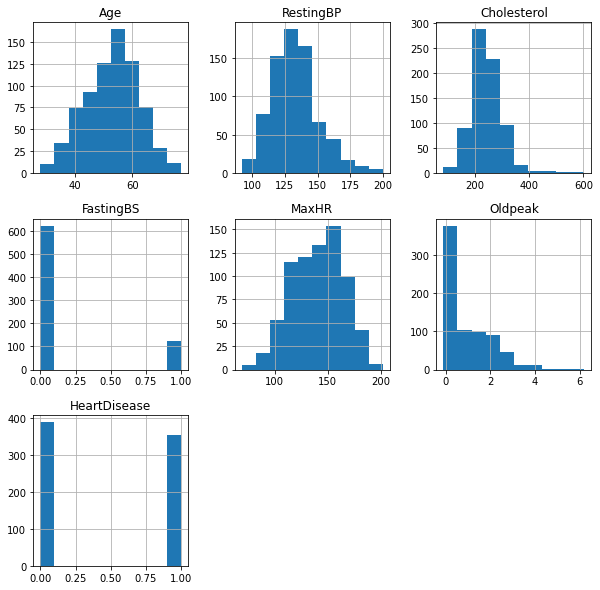

In [12]:
df.hist(figsize=(10,10))

<AxesSubplot:>

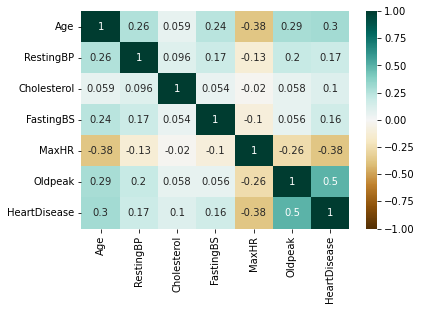

In [13]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

<AxesSubplot:xlabel='Age', ylabel='MaxHR'>

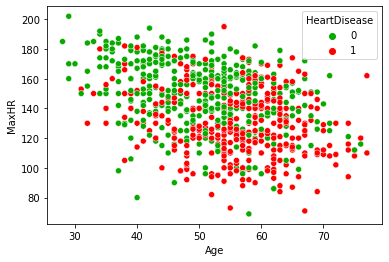

In [14]:
# set colors for heartdisease
colors = ['#09AA00', '#ff0000']
sns.scatterplot(x="Age", y="MaxHR", hue="HeartDisease", data=df, palette=colors)


<AxesSubplot:xlabel='Age', ylabel='RestingBP'>

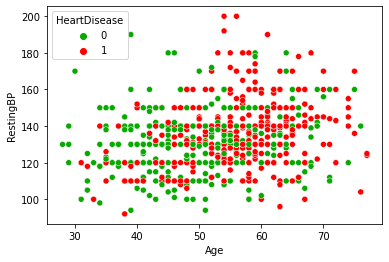

In [15]:
sns.scatterplot(x="Age", y="RestingBP", hue="HeartDisease",data=df, palette=colors)

<AxesSubplot:xlabel='Age', ylabel='Oldpeak'>

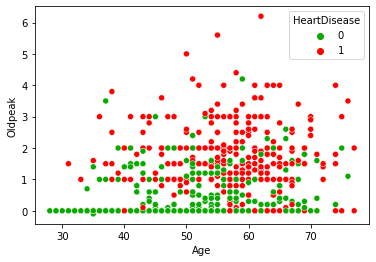

In [16]:
sns.scatterplot(x="Age", y="Oldpeak", hue="HeartDisease" ,data=df, palette=colors)

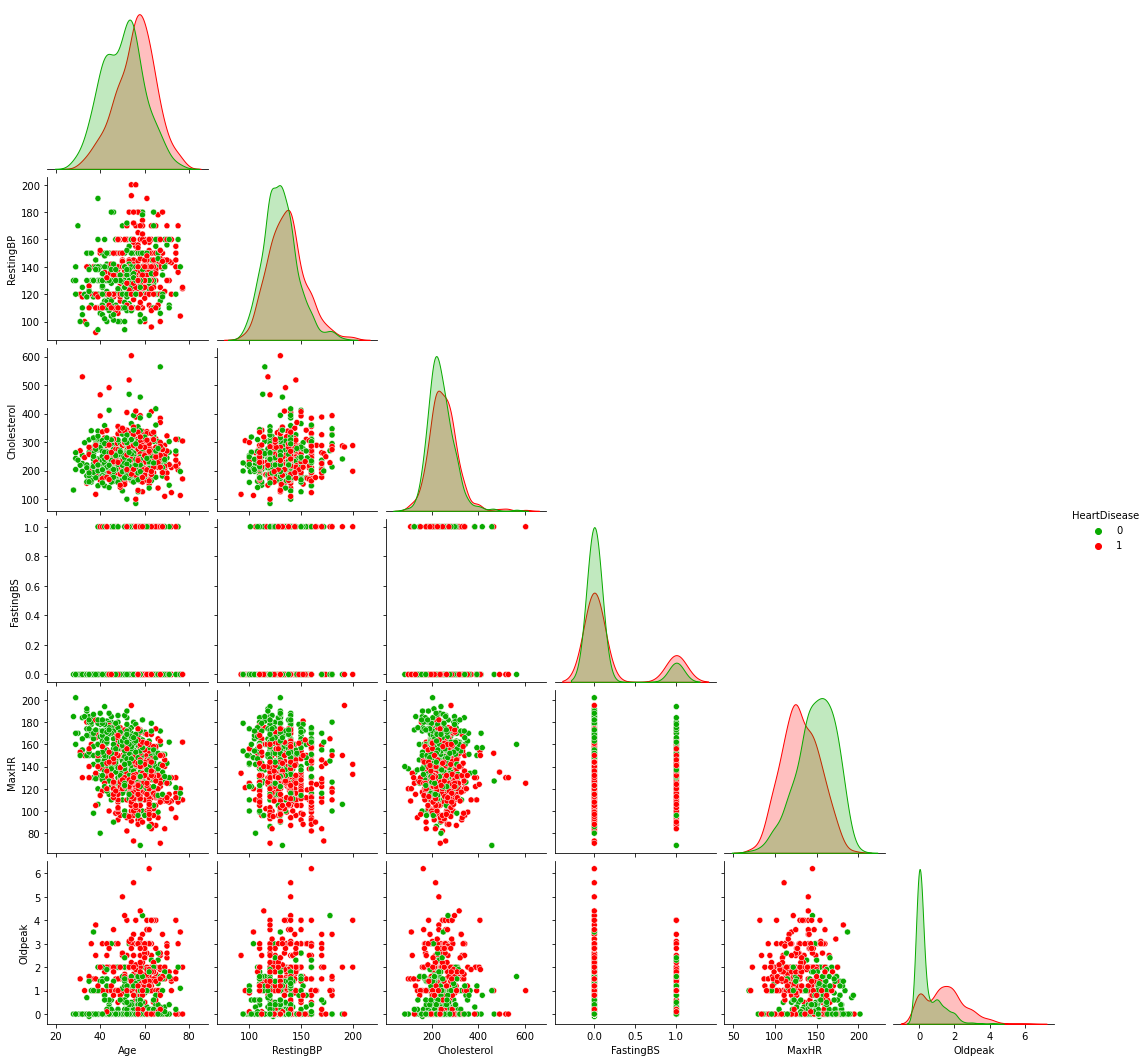

In [17]:
sns.pairplot(df, hue="HeartDisease", corner=True, palette=colors)

<AxesSubplot:xlabel='Sex', ylabel='Age'>

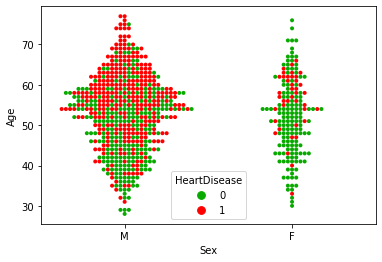

In [18]:
sns.swarmplot(y="Age", x="Sex", hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='RestingECG', ylabel='Age'>

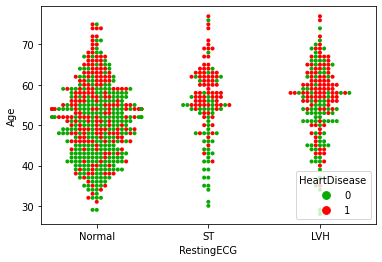

In [19]:
sns.swarmplot(y='Age', x='RestingECG', hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='ChestPainType', ylabel='Age'>

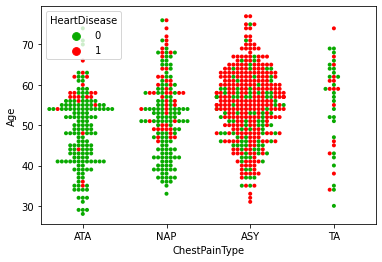

In [20]:
sns.swarmplot(y="Age", x="ChestPainType", hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='ST_Slope', ylabel='Age'>

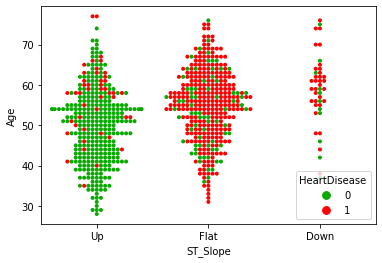

In [21]:
sns.swarmplot(y="Age", x="ST_Slope", hue="HeartDisease", data=df, s=4, palette=colors)

<AxesSubplot:xlabel='ExerciseAngina', ylabel='Age'>

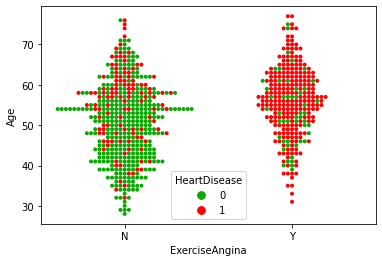

In [22]:
#Print influence of stress-dependent angina pectoris => YES strong correlation
sns.swarmplot(y="Age", x="ExerciseAngina", hue="HeartDisease", data=df, s=4, palette=colors)

In [23]:
# determine categorical features
categ = df.select_dtypes(include=object).columns
print(categ)
# convert categorical features to numeric
df = pd.get_dummies(df, columns=categ, drop_first=True)
# Print first 5 rows
df.head()

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [24]:
y, X = df['HeartDisease'], df.drop(columns='HeartDisease')

In [25]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

0    390
1    356
Name: HeartDisease, dtype: int64
0    390
1    390
Name: HeartDisease, dtype: int64


Text(0.5, 1.0, 'HeartDiseases')

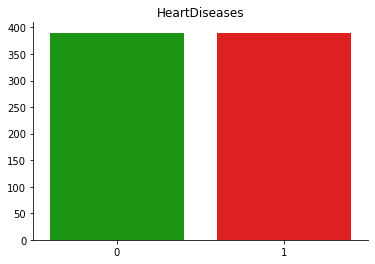

In [26]:
# print unbalanced classes 
labels_count = y.value_counts()
print(labels_count)

# oversample minority class with SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# print balanced classes 
labels_count = y.value_counts()
print(labels_count)

# plot HeartDisease
s = sns.barplot(x=labels_count.index, y=labels_count.values, palette=colors)
sns.despine()
s.set_xticklabels(s.get_xticklabels())
s.set_title('HeartDiseases')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(702, 15)
(78, 15)
(702,)
(78,)


In [28]:
def createModel(activation_func, learning_rate):
    model = Sequential()

    # input to 1. hidden layer
    model.add(Dense(units=512, input_dim=X_train.shape[1]))
    model.add(Activation(activation_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # 2. hidden layer
    model.add(Dense(256))
    model.add(Activation(activation_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # 3. hidden layer
    model.add(Dense(128))
    model.add(Activation(activation_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    # output layer
    model.add(Dense(1))
    model.add(Activation("sigmoid")) # (0, 1): value > 0.5 => class 1, else class 0
    model.summary()

    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    
    return model

# create model
model = KerasClassifier(build_fn=createModel, verbose=1)

# define hyperparameters
batch_size = [90] # [60, 90, 120]
epochs = [10] # [10, 20, 40]
activation_funcs = ['tanh']
learning_rate = [0.0001] # [0.001, 0.0001, 0.00001]

# collect hyperparamters to grid
param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  activation_func=activation_funcs,
                  learning_rate=learning_rate)

# create stratisfied k-folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=cv, scoring='accuracy') # not use n_jobs=-1 with keras
# run gridsearch
grid_res = grid.fit(X_train, y_train)

2022-04-18 22:45:03.660578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               8192      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

2022-04-18 22:45:03.892306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


8/8 [==============================] - 1s 15ms/step - loss: 0.7253 - accuracy: 0.6387
Epoch 2/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4504 - accuracy: 0.8035
Epoch 3/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4178 - accuracy: 0.8368
Epoch 4/10
8/8 [==============================] - 0s 15ms/step - loss: 0.3978 - accuracy: 0.8447
Epoch 5/10
8/8 [==============================] - 0s 15ms/step - loss: 0.3850 - accuracy: 0.8415
Epoch 6/10
8/8 [==============================] - 0s 15ms/step - loss: 0.3922 - accuracy: 0.8447
Epoch 7/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4095 - accuracy: 0.8368
Epoch 8/10
8/8 [==============================] - 0s 15ms/step - loss: 0.4167 - accuracy: 0.8193
Epoch 9/10
8/8 [==============================] - 0s 15ms/step - loss: 0.3658 - accuracy: 0.8590
Epoch 10/10
8/8 [==============================] - 0s 14ms/step - loss: 0.3920 - accuracy: 0.8510
Model: "sequential_1"
__________________

In [30]:
#Print model score with optimal hyperparameters
print("Optimal")
print("Accuracy:", grid_res.best_score_)
print("Std:", grid_res.cv_results_['std_test_score'][grid_res.best_index_])
print("Hyperparams:", grid_res.best_params_)

Optimal
Accuracy: 0.8613816230717638
Std: 0.0386148078215806
Hyperparams: {'activation_func': 'tanh', 'batch_size': 90, 'epochs': 10, 'learning_rate': 0.0001}


In [31]:
#Train model with optimale hyperparameters and complete train dataset

model = KerasClassifier(build_fn=createModel,
                        batch_size=grid_res.best_params_['batch_size'],
                        epochs=grid_res.best_params_['epochs'],
                        activation_func=grid_res.best_params_['activation_func'],
                        learning_rate=grid_res.best_params_['learning_rate'])

model.fit(x=X_train, y=y_train)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 512)               8192      
_________________________________________________________________
activation_124 (Activation)  (None, 512)               0         
_________________________________________________________________
batch_normalization_93 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_93 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_125 (Activation)  (None, 256)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 256)             

<AxesSubplot:>

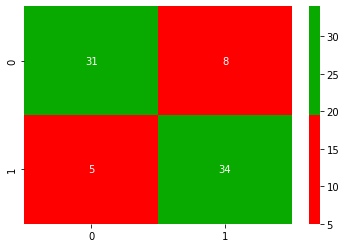

In [32]:
# predict labels
y_pred = model.predict(X_test)
# compare with true labels
cfm = confusion_matrix(y_test, y_pred)
# print confusion matrix
sns.heatmap(cfm, annot=True, cmap=['#ff0000', '#09AA00'])